# Week 4 - Semantic & Influence Networks

This week, we explore the representation and analysis of semantic and influence networks. We begin by introducing you to some straightforward approaches to network analysis. We then begin to illustrate them with word networks that we can analyze to understand the structure of how words connect with one another, and the dynamics of how their meanings flow through a discursive system. For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify them). Rendering words linked as a network or discrete topology allows us to take advantage of the network analysis metrics like centrality and community.

Texts also represent moves in a social game, and we can analyze the interchange of words and phrases within them in order to understand more about the relationships between people, groups and organizations that interact with one another. For example, who influences whom? And in a singular conversation--like a discussion of tweets on comments in Facebook--or over vast stretches of time (e.g., How much was Kant influenced by Aristotle? by Plato? Was _Chinatown_ director Robert Towne influenced by Sophocles?) We will do this by extracting conversational moves from text. But note that the similarity measures from last week's homework can also be used to represent a matrix of similarities--and potential influences--from one document to another. Rendering social actors or documentary events (e.g., a book) linked as a network or discrete topology allows us to take advantage of the wide range of metrics and models developed for network analysis. These include measurement of network centrality, density and modularity, "block modeling" structurally equivalent relationships, and sophisticated graphical renderings of networks or network partitions that allow us to visually interrogate their structure and complexity of social relations. Moreover, we can link explicit social interactions (e.g., "friendship" on Facebook, coupling in a romantic relationship, etc.) with semantic networks to better make sense of how pepole (inter)act in the world. 

For this notebook we will use the following packages:

In [7]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas as pd #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn as sb #Makes the plots look nice
import scipy #Some stats
import spacy
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

#other packages
import sklearn.feature_extraction
from networkx.algorithms.community import greedy_modularity_communities
import re

## <span style="color:blue">*Exercise 1*</span>

<span style="color:blue">Construct cells immediately below this that render networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that give insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

    I will be using 'Harry Potter and the Sorcerer's Stone' for the following analysis. I believe I would be able to understand the following analyses better with something that I'm familiar with. The txt was downloaded from: <http://www.pauladaunt.com/books/Children's/Harry_Potter1-4/J.%20K.%20Rowling%20-%20Harry%20Potter%201%20-%20Sorcerer's%20Stone.txt>

### Data Preprocessing

In [1]:
with open('/Users/Selina/Desktop/2020 Spring/Content Analysis/harrypotter1.txt', 'r') as file:
    data = file.read()

In [2]:
hp = list(data.replace('\n', ' ')[40:].split('  '))

In [3]:
hp = map(str.strip, hp) #remove trailing & leading white spaces

In [4]:
hp = [x for x in hp if not x.startswith('CHAPTER')] #remove chapter numbers

In [5]:
hp[:5]

['THE BOY WHO LIVED',
 "Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense.",
 'Mr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large mustache. Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. The Dursleys had a small son called Dudley and in their opinion there was no finer boy anywhere.',
 "The Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. They didn't think they could bear it if anyone found out about the Potters. Mrs. Potter was Mrs. Dursley's sister, but t

In [222]:
hp = pd.DataFrame(hp)
hp.columns=['para']

In [223]:
hp.to_csv('harrypotter1_cleaned.csv', index=False)

### Network & Visualizations

In [8]:
hp = pd.read_csv('harrypotter1_cleaned.csv')

In [225]:
#tokenize and normalize paragraphs
hp['tokenized_para'] = hp['para'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
hp['normalized_para'] = hp['tokenized_para'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [226]:
hp['normalized_para'][3] #a list (of sentences) of list (of words)

[['dursleys', 'want', 'secret', 'great', 'fear', 'somebody', 'discover'],
 ['think', 'bear', 'find', 'potter'],
 ['mrs',
  'potter',
  'mrs',
  'dursley',
  'sister',
  'meet',
  'year',
  'fact',
  'mrs',
  'dursley',
  'pretend',
  'sister',
  'sister',
  'good',
  'husband',
  'undursleyish',
  'possible'],
 ['dursleys', 'shudder', 'think', 'neighbor', 'potter', 'arrive', 'street'],
 ['dursleys', 'know', 'potter', 'small', 'son', 'see'],
 ['boy',
  'good',
  'reason',
  'keep',
  'potter',
  'away',
  'want',
  'dudley',
  'mix',
  'child',
  'like']]

In [227]:
#define function to construct co-occurence matrix 
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [228]:
g = wordCooccurrence(hp['normalized_para'][:200].sum()) #look at the first 200 paragraphs

In [229]:
nx.to_numpy_matrix(g)[:10, :10] #check the adjacency matrix

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 2., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 2., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 2., 0., 1., 0., 0., 0., 0., 2., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [230]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

In [231]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(hp['para'][:200])
senVects_incidence.shape

(200, 1087)

In [232]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), 
                       bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), 
                       bipartite = 'doc')
#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], 
                         {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [233]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 1287
Number of edges: 2983
Average degree:   4.6356


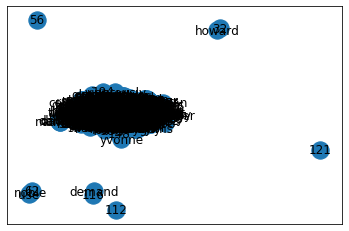

In [234]:
nx.draw_networkx(g_2mode)

    The above looks like a very interesting graph, e.g. we see 'howard' on the outside, which makes sense because I dont even remember who Howard is. Let's further filter it to extract more information.

**Document-to-document network**

In [235]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [236]:
gDoc = contractNetwork(g_2mode, 'doc')
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 200
Number of edges: 7534
Average degree:  75.3400


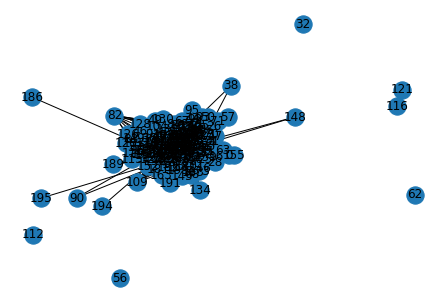

In [237]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

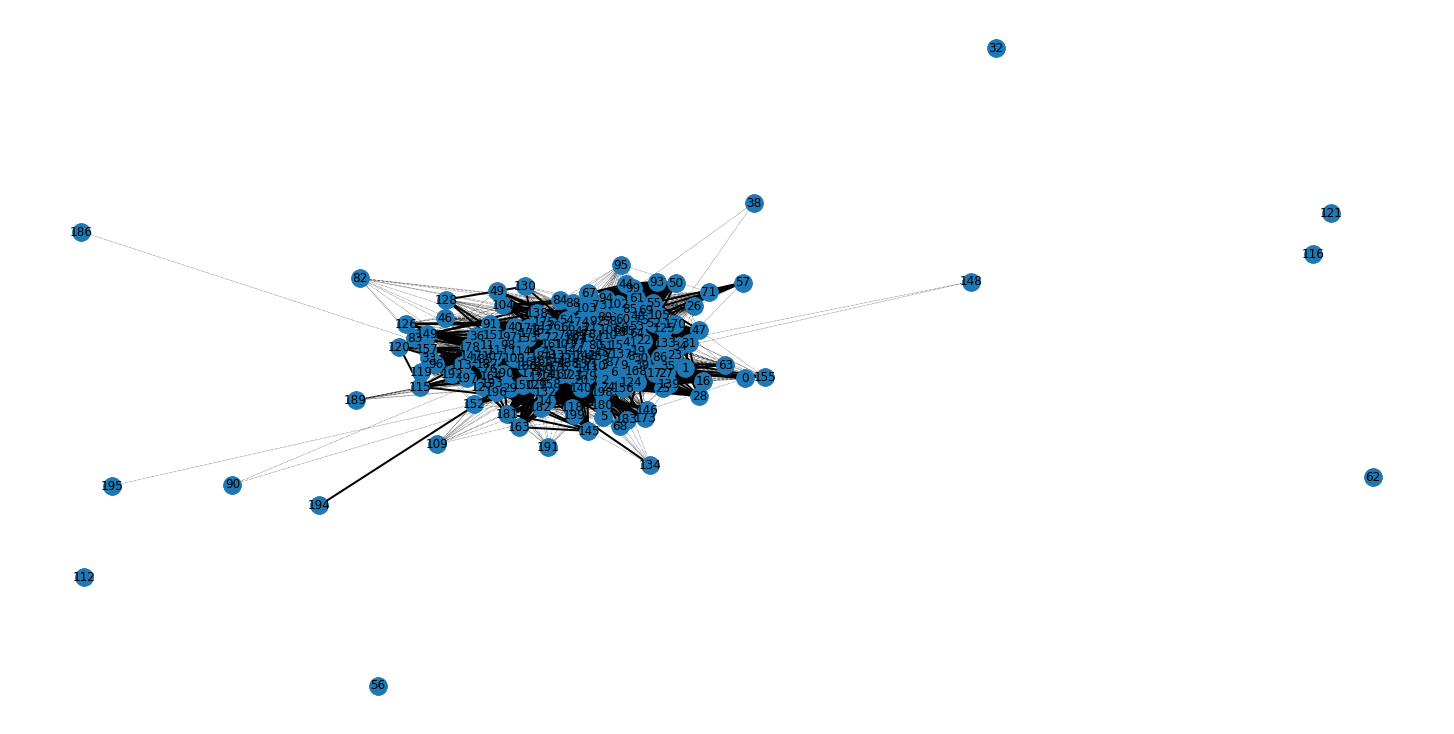

In [245]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
plt.figure(figsize = (20,10))
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

    Let's examine some outliers and insiders to get a sense of what is going on.

In [252]:
#outlier
print(len(hp.iloc[62]['para']),"words:","\n",hp.iloc[62]['para'])

55 words: 
 "Only because you're too -- well -- noble to use them."


In [253]:
#outlier
print(len(hp.iloc[186]['para']),"words:","\n",hp.iloc[186]['para'])

10 words: 
 It winked.


In [254]:
#central (relatively, because I really can't see the center very well)
print(len(hp.iloc[9]['para']),"words:","\n",hp.iloc[9]['para'])

696 words: 
 Mr. Dursley always sat with his back to the window in his office on the ninth floor. If he hadn't, he might have found it harder to concentrate on drills that morning. He didn't see the owls swoop ing past in broad daylight, though people down in the street did; they pointed and gazed open- mouthed as owl after owl sped overhead. Most of them had never seen an owl even at nighttime. Mr. Dursley, however, had a perfectly normal, owl-free morning. He yelled at five different people. He made several important telephone calls and shouted a bit more. He was in a very good mood until lunchtime, when he thought he'd stretch his legs and walk across the road to buy himself a bun from the bakery.


In [255]:
#central
print(len(hp.iloc[23]['para']),"words:","\n",hp.iloc[23]['para'])

191 words: 
 Mr. Dursley sat frozen in his armchair. Shooting stars all over Britain? Owls flying by daylight? Mysterious people in cloaks all over the place? And a whisper, a whisper about the Potters...


    So longer paragraphs are more central in this network. It make sense that the graph is shaped like this now. In Harry Potter, there might be some paragraphs that only have one or two words, such as 'it winked' presented above. These paragraphs are likely to be distributed on the outside of the network as they might not be connected with any other paragraph.

**Word-to-word network**

In [347]:
g = wordCooccurrence(hp['normalized_para'].sum())

In [348]:
len(g)

3932

In [349]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 15])

In [350]:
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [351]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [352]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 107
Number of edges: 188
Average degree:   3.5140


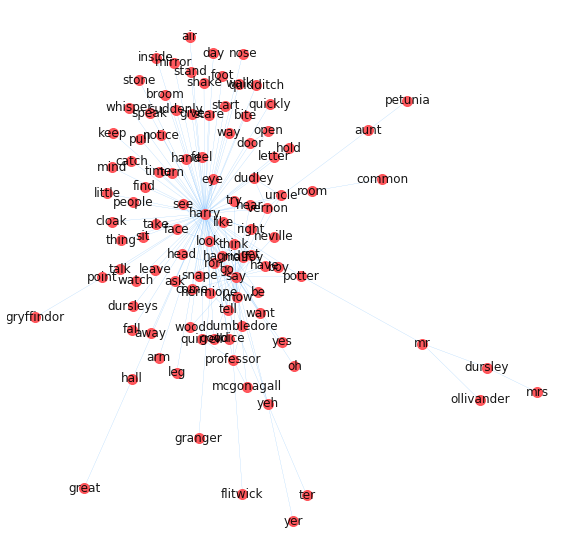

In [353]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

    Regardless of the value of weight threshold, the network follows similar shape as the graph presented above (weight = 15), with 'harry' in the middle of everything. We see that words like dumbledor, mirror, snape, are on the outside, whereas flitwick, gryffindor are even further out from the center.

In [354]:
#now let's see if there's any click
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

harry, say, look, ron, hermione, go


    Haha, this is unsurprising. In this book Harry's probably almost always associated with Ron and Hermione.

In [355]:
#let's manually examine 'Hermione'
wordNeighbors = giant.neighbors('hermione')
g_word = giant.subgraph(wordNeighbors)
print(nx.info(g_word))

Name: 
Type: Graph
Number of nodes: 7
Number of edges: 17
Average degree:   4.8571


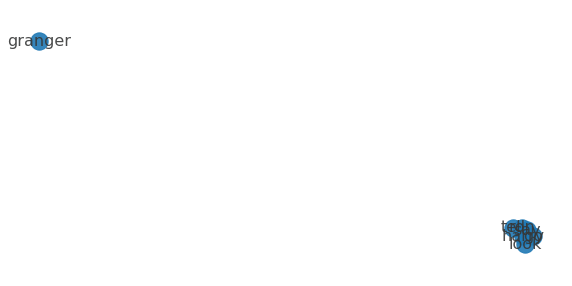

In [360]:
layout_amer = nx.spring_layout(g_word, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,5))
maxWeight = max((d['weight'] for n1, n2, d in g_word.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_word.edges(data = True)))
nx.draw(g_word, ax = ax, pos = layout_amer, labels = {n:n for n in g_word.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_word.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

    We see 'granger' on one side, and a bunch of indistinguishable verbs on the other side. So Granger is related with Hermione (of course), but it's not related with the other words.

In [361]:
#now let's find 'ron''s neighbor
wordNeighbors = giant.neighbors('ron')
wordNeighborsPlus1 = set(wordNeighbors)
for n in wordNeighbors:
    wordNeighborsPlus1 |= set(giant.neighbors(n))

In [362]:
g_word2 = giant.subgraph(wordNeighborsPlus1)
print(nx.info(g_word2))

Name: 
Type: Graph
Number of nodes: 12
Number of edges: 43
Average degree:   7.1667


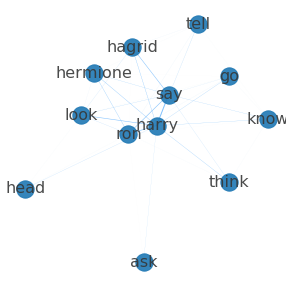

In [363]:
layout_amer = nx.spring_layout(g_word2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (5,5))
centralities_amer = nx.eigenvector_centrality(g_word2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_word2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_word2.edges(data = True)))
nx.draw(g_word2, ax = ax, pos = layout_amer, labels = {n:n for n in g_word2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_word2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

    Again, we see Hermione and Harry in the neighbor network. Hagrid is also in the network, along with a list of verbs.

## <span style="color:blue">*Exercise 2*</span>

<span style="color:blue">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

**Degree of Centrality**

In [364]:
dcentralities = nx.degree_centrality(giant)

In [365]:
sorted(dcentralities.items(), reverse = True, key = lambda x:x[1])[:30]

[('harry', 0.8584905660377358),
 ('say', 0.33962264150943394),
 ('look', 0.14150943396226415),
 ('ron', 0.12264150943396226),
 ('know', 0.09433962264150943),
 ('go', 0.07547169811320754),
 ('get', 0.07547169811320754),
 ('professor', 0.07547169811320754),
 ('yeh', 0.0660377358490566),
 ('tell', 0.0660377358490566),
 ('hermione', 0.0660377358490566),
 ('have', 0.05660377358490566),
 ('hagrid', 0.05660377358490566),
 ('be', 0.04716981132075471),
 ('like', 0.04716981132075471),
 ('think', 0.04716981132075471),
 ('dudley', 0.04716981132075471),
 ('uncle', 0.04716981132075471),
 ('vernon', 0.03773584905660377),
 ('potter', 0.02830188679245283),
 ('dumbledore', 0.02830188679245283),
 ('malfoy', 0.02830188679245283),
 ('head', 0.02830188679245283),
 ('snape', 0.02830188679245283),
 ('mr', 0.02830188679245283),
 ('ter', 0.02830188679245283),
 ('point', 0.018867924528301886),
 ('see', 0.018867924528301886),
 ('good', 0.018867924528301886),
 ('quirrell', 0.018867924528301886)]

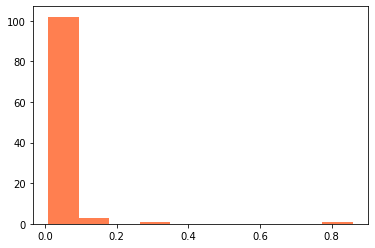

In [371]:
#show distribution of degree of centrality
plt.hist(list(dcentralities.values()), color='coral');

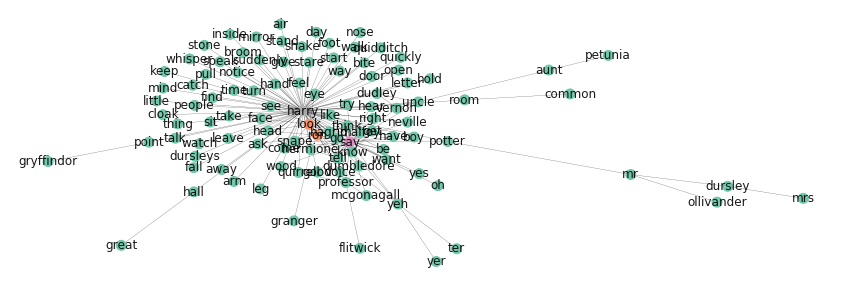

In [373]:
#color by degree of centrality
fig, ax = plt.subplots(figsize = (15,5))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('Set2')) 

    A node's degree centrality is defined as the number of connections connected to a node. Here our measure normalizes the number of connections by those with the most connections. Unsurprisingly, Harry has the highest degree of centrality. We also see Ron at the top of the list. Hermione however, did not even make it to top 10. She's not even as central as 'professor'. This is surprising yet interesting.

**Betweenness Centrality**

In [404]:
#The betweenness centrality for each vertex is the number of shortest paths that pass through the vertex.
centralities = nx.betweenness.betweenness_centrality(giant)

In [405]:
sorted(centralities.items(), reverse = True, key = lambda x:x[1])[:30]

[('harry', 0.8721717366191759),
 ('say', 0.13248919693663627),
 ('potter', 0.07331536388140161),
 ('mr', 0.055884995507637016),
 ('uncle', 0.0377088948787062),
 ('yeh', 0.03755615453728661),
 ('professor', 0.024992512728361786),
 ('hermione', 0.01893980233602875),
 ('point', 0.018867924528301886),
 ('aunt', 0.018867924528301886),
 ('dursley', 0.018867924528301886),
 ('hall', 0.018867924528301886),
 ('room', 0.018867924528301886),
 ('know', 0.01228340392760878),
 ('tell', 0.012211526119881915),
 ('look', 0.006084798699353955),
 ('ron', 0.0030342703118983435),
 ('go', 0.0006768493560946391),
 ('vernon', 0.0003324348607367476),
 ('get', 0.00023659778376759508),
 ('hagrid', 0.00016172506738544476),
 ('think', 0.00010482180293501046),
 ('have', 4.4923629829290206e-05),
 ('day', 0.0),
 ('quickly', 0.0),
 ('nose', 0.0),
 ('cloak', 0.0),
 ('stand', 0.0),
 ('feel', 0.0),
 ('common', 0.0)]

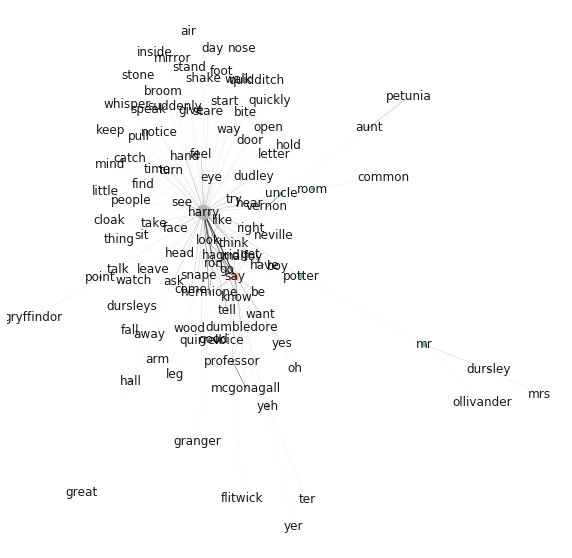

In [407]:
#graph betweeness
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC *100 for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('Set2')) 

    Even after changing the normalization criteria, we see that these words' betweenness centralities are too small to be colored on the graph. Using the betweeness measure, "mr" and "potter" made it to top 10 of the centrality list. This is interesting, maybe Mr Potter was used to connect other words in a sentence more often than the other words.

**Eigenvector Centrality**

Eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an $n$th order degree measure.

In [408]:
centralities = nx.eigenvector_centrality(giant)

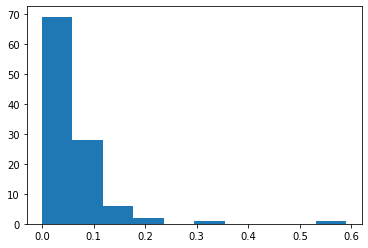

In [412]:
plt.hist(list(centralities.values()))
plt.show()

In [409]:
sorted(centralities.items(), reverse = True, key = lambda x:x[1])[:30]

[('harry', 0.5903596658263499),
 ('say', 0.34947679789094016),
 ('look', 0.19351372759571853),
 ('ron', 0.1923788758474302),
 ('know', 0.15785483284781623),
 ('go', 0.15476622364350165),
 ('get', 0.1360171667351936),
 ('hermione', 0.13573344356447273),
 ('tell', 0.13503191082777546),
 ('hagrid', 0.13322431011472483),
 ('think', 0.11669184502373259),
 ('have', 0.10855503892824568),
 ('like', 0.10316674131347756),
 ('professor', 0.10295481076949786),
 ('be', 0.09963960512375407),
 ('malfoy', 0.09455931239745374),
 ('snape', 0.09455931239745374),
 ('uncle', 0.0926273000862437),
 ('vernon', 0.09202799638537966),
 ('dumbledore', 0.08700366978440076),
 ('head', 0.08145202496487182),
 ('potter', 0.0789714248971887),
 ('good', 0.07841391012275228),
 ('right', 0.07841391012275228),
 ('hear', 0.07841391012275228),
 ('come', 0.07841391012275228),
 ('voice', 0.07841391012275228),
 ('neville', 0.07841391012275228),
 ('boy', 0.07841391012275228),
 ('want', 0.07841391012275228)]

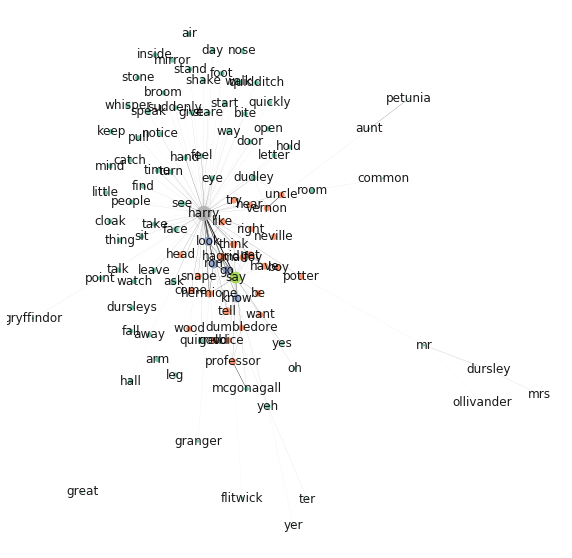

In [411]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('Set2')) 

    Comparing the above graph with the other centrality measure, eigen vector centrality's distribution is more gradual. Again, we see Harry on the top, and Ron, Hermione among the top 10.

**Closeness Centrality** 

Nodes with a high closeness score have the shortest distances to all other nodes.

In [413]:
centralities = nx.closeness_centrality(giant)

In [415]:
sorted(centralities.items(), reverse = True, key = lambda x:x[1])[:30]

[('harry', 0.8153846153846154),
 ('say', 0.5698924731182796),
 ('look', 0.49074074074074076),
 ('ron', 0.48623853211009177),
 ('tell', 0.4818181818181818),
 ('potter', 0.4818181818181818),
 ('know', 0.4818181818181818),
 ('go', 0.4796380090497738),
 ('hermione', 0.4774774774774775),
 ('uncle', 0.4774774774774775),
 ('professor', 0.47533632286995514),
 ('get', 0.4732142857142857),
 ('vernon', 0.4732142857142857),
 ('hagrid', 0.4732142857142857),
 ('think', 0.4711111111111111),
 ('dumbledore', 0.4690265486725664),
 ('have', 0.4690265486725664),
 ('be', 0.4669603524229075),
 ('like', 0.4669603524229075),
 ('malfoy', 0.4669603524229075),
 ('snape', 0.4669603524229075),
 ('good', 0.4649122807017544),
 ('right', 0.4649122807017544),
 ('hear', 0.4649122807017544),
 ('come', 0.4649122807017544),
 ('voice', 0.4649122807017544),
 ('neville', 0.4649122807017544),
 ('boy', 0.4649122807017544),
 ('want', 0.4649122807017544),
 ('wood', 0.4649122807017544)]

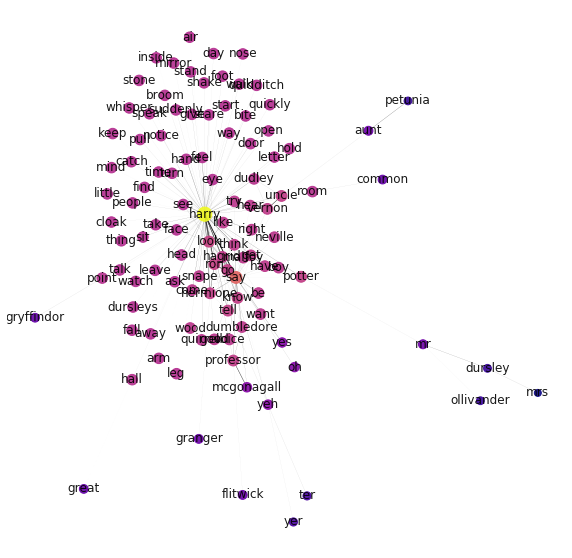

In [414]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

    An interesting thing to note is that 'harry' and 'say' have always been the top 2 on the sorted centrlaity list, regardless of the centrality measure. It probably implies that the novel is mainly composed of dialogues. This might also explain why the network is mostly composed of names or pronouns. Other than Harry, Ron, and Hermione, we also see 'professor', 'uncle', 'hagrid', 'malfoy', 'nelville', 'dumbledore' present as words with the highest centrality scores. 

**Filter by Centrality**

In [416]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [417]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 71
Average degree:   5.6800


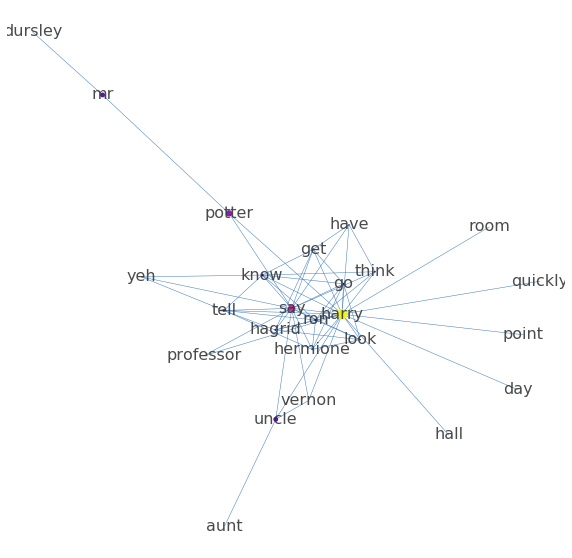

In [421]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'));

    This is nothing surprising. If not for the verbs, it almost looks like a inter-personal relationship network, which make sense because the story is mainly driven by what is happening to each character. We see Harry in the middle, ron, hagrid, hermione and professor surrounding him, and more trivial characters such as 'aunt' and 'dursley' (the mean family) farther away from the center.

In [425]:
#check the density of this network
#defined as the number of actual edges divided by the total number of possible edges
nx.density(giant)

0.03315111973196967

In [426]:
#average degree per node in giant
np.mean([v for w,v in nx.degree(giant)])

3.514018691588785

In [427]:
#average distance between two nodes in the network
nx.diameter(giant)

7

    The density of this network is 0.03315, which means only 3% of total possible edges are actual edges. Average degree per node is 3.5, whereas average distance between two nodes is 7. Referring to the theory of 'six degree of separation', I think the number '7' makes a lot of sense, given that many words in our network are actually names.

## <span style="color:blue">*Exercise 3*</span>

<span style="color:blue">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:blue">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

**Part of Speech Network**  
**Noun-Noun pairs**

In [429]:
nlp = spacy.load('en')

In [430]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [432]:
gNN = posCooccurrence(hp['normalized_para'].sum(), 'NN')

In [433]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 1832
Number of edges: 11368
Average degree:  12.4105


In [434]:
#remove less significant nodes
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 100]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 18
Number of edges: 118
Average degree:  13.1111


In [435]:
#remove less significant edges
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 18
Number of edges: 40
Average degree:   4.4444


In [485]:
def plot_network(gNN):
    layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
    fig, ax = plt.subplots(figsize = (10,10))
    centralities_nn = nx.eigenvector_centrality(gNN)
    maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
    maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
    minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
    nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
            #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
            alpha = .9, 
            node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
            node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
            font_size = 16,
            font_color = 'xkcd:dark grey',
            edge_color = 'xkcd:medium blue',
            cmap = plt.get_cmap('Oranges'))

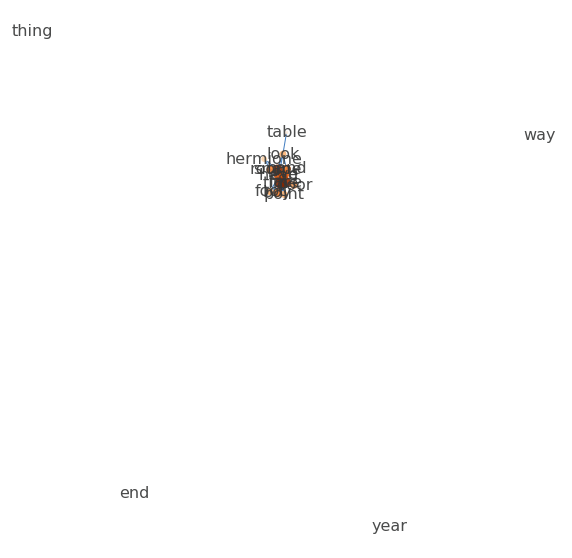

In [486]:
plot_network(gNN)

    We can't really distinguish the words in the center, however we see 'end', 'way', 'year', 'thing' on the outside, not connected with the other words.

**Noun-Verb pairs (& Name-Verb pairs)**

In [487]:
#noun-verb pairs
gNV = posCooccurrence(hp['normalized_para'].sum(), 'NN', 'VB')

In [488]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 1977
Number of edges: 18222
Average degree:  18.4340


In [489]:
#remove noun-noun and verb-verb
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if 
                       gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [490]:
#remove less significant nodes and edges
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [491]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 23
Number of edges: 59
Average degree:   5.1304


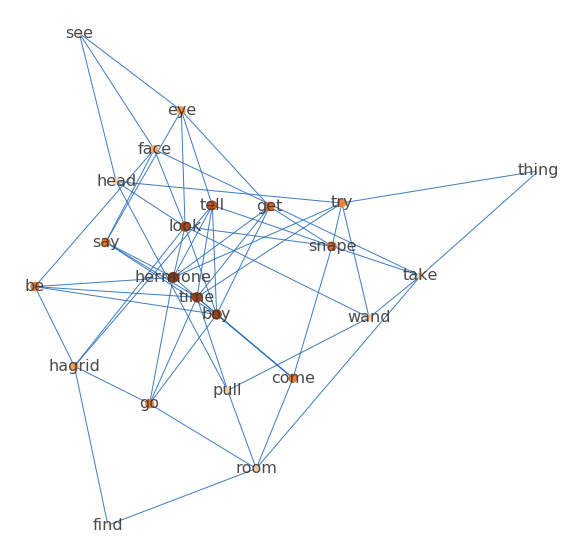

In [492]:
plot_network(gNV)

    We see basic verbs like 'say', 'take', 'get', 'go', 'be', 'find', 'pull'..Some interesting nouns are 'wand', 'eye', and 'boy'. The only three names that we have here are 'Hermione', 'Snape' and 'Hagrid'. Harry, Ron, Malfoy and others are not present in this network.  It's possible that Harry and Ron are more common names, and so they are labeled as names rather than NN, whereas Hermione, a less common name, is labeled as NN. To verify this, let's look at name-verb pairs:

In [501]:
#name-verb pairs
gNPV = posCooccurrence(hp['normalized_para'].sum(), 'NNP', 'VB')

In [502]:
#remove name-name and verb-verb
gNPV.remove_edges_from([(n1,n2) for n1,n2,d in gNPV.edges(data = True) if 
                       gNPV.nodes[n1]['bipartite'] == gNPV.nodes[n2]['bipartite']])

In [503]:
print(nx.info(gNPV))

Name: 
Type: Graph
Number of nodes: 2457
Number of edges: 5347
Average degree:   4.3525


In [504]:
#remove less significant nodes and edges
gNPV.remove_edges_from([(n1, n2) for n1, n2, d in gNPV.edges(data = True) if d['weight'] <= 2])
gNPV.remove_nodes_from([n for n in gNPV.nodes if len(set(gNPV.neighbors(n))) <= 5])
print(nx.info(gNPV))

Name: 
Type: Graph
Number of nodes: 27
Number of edges: 102
Average degree:   7.5556


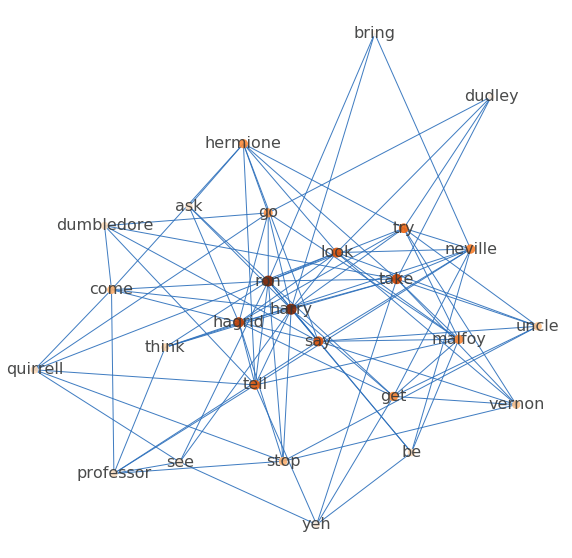

In [505]:
plot_network(gNPV)

    My previous hypothesis was true. Harry and Ron are indeed labeled as NNP rather than NN. We see here that 'say' remains an important verb. Other basic verbs like be, go, get, come are also present in the network. Again, we see that harry is in the center, whereas malfoy, nelveille are farther out in the network.

**Ego Network**

In [506]:
g_i = gNPV.subgraph(['harry'] + list(gNPV.neighbors('harry')))

In [507]:
print(nx.info(g_i))

Name: 
Type: Graph
Number of nodes: 15
Number of edges: 14
Average degree:   1.8667


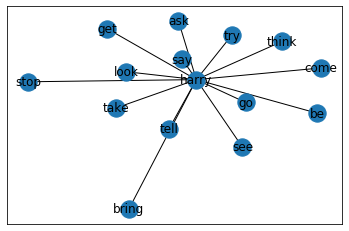

In [508]:
nx.draw_networkx(g_i)

    Harry is doing all these basic things like look, take, tell, see, and ask. A wizard is not so different from us after all.

In [511]:
#let's see who are 'think'ing the most
storyNeighbors = gNPV.neighbors('think')
set(storyNeighbors)

{'hagrid', 'harry', 'neville', 'professor', 'ron'}

In [514]:
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNPV.neighbors(n))

In [516]:
gNPV_story = gNPV.subgraph(storyNeighborsPlus1)
print(nx.info(gNPV_story))

Name: 
Type: Graph
Number of nodes: 19
Number of edges: 54
Average degree:   5.6842


In [517]:
sorted(nx.degree_centrality(gNPV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('harry', 0.7777777777777777),
 ('ron', 0.7777777777777777),
 ('hagrid', 0.611111111111111),
 ('neville', 0.5),
 ('professor', 0.3333333333333333),
 ('tell', 0.2777777777777778),
 ('think', 0.2777777777777778),
 ('say', 0.2777777777777778),
 ('look', 0.2222222222222222),
 ('come', 0.2222222222222222)]

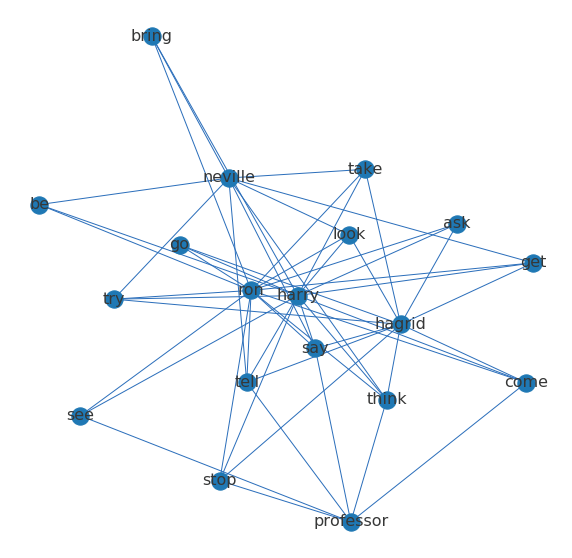

In [519]:
layout_story = nx.spring_layout(gNPV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNPV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNPV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue') 

    Again, interestingly, Hermione is not in the network. Probably because most of hte time Hermione is categorized as a normal noun, so it's not presented in this network.

## <span style="color:blue">*Exercise 4*</span>

<span style="color:blue">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project. Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<span style="color:blue">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<span style="color:blue">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

**Relationship between characters**

    Harry Potter is not a TV script. Given this, we will change our approach slightly to examine whether different characters are mentioned in the same sentence, instead whether they talked with one another, and construct a network based on this. This would therefore include any direct dialogue interactions between two characters, as well as being mentioned or described together.

In [542]:
tokenized_words = []
for array in hp['tokenized_para']:
    for each_list in array:
        tokenized_words += each_list

In [543]:
print("There are", len(tokenized_words), " tokenized words in Harry Potter I")
#check the format

There are 80544  tokenized words in Harry Potter I


In [564]:
characters = {'Harry':0, 'Hermione': 0, 'Ron': 0, 'Malfoy':0, 'McGonagall':0, 
              'Dursley':0, 'Snape':0, 'Dumbledore':0, 'Hagrid':0, 'Voldemort':0}

def count_freq_character(characters):
    char = ['Harry', 'Hermione','Ron', 'Malfoy', 'McGonagall', 'Dursley', 
            'Snape', 'Dumbledore', 'Hagrid', 'Voldemort']
    for word in tokenized_words:
        if word in char:
            characters[word]+=1
    return characters

In [566]:
characters = count_freq_character(characters)

In [567]:
characters

{'Harry': 1324,
 'Hermione': 269,
 'Ron': 429,
 'Malfoy': 122,
 'McGonagall': 101,
 'Dursley': 54,
 'Snape': 172,
 'Dumbledore': 156,
 'Hagrid': 370,
 'Voldemort': 37}

In [582]:
#create graph
char_network = nx.Graph()
#add node
for character in characters:
    char_network.add_node(character, mentioned=characters[character])

In [583]:
char = ['Harry', 'Hermione','Ron', 'Malfoy', 'McGonagall', 'Dursley', 
        'Snape', 'Dumbledore', 'Hagrid', 'Voldemort']

#loop through data to find characters that appear in the same sentence
for array in hp['tokenized_para']:
    for sentence in array:
        for word_1 in sentence:
            for word_2 in sentence:
                if word_1 in char and word_2 in char and word_1!=word_2:
                    if(word_1, word_2) not in char_network.edges():
                        char_network.add_edge(word_1,word_2, weight = 0)
                    else:
                        char_network.edges[(word_1, word_2)]['weight'] +=1

In [584]:
print(nx.info(char_network))

Name: 
Type: Graph
Number of nodes: 10
Number of edges: 34
Average degree:   6.8000


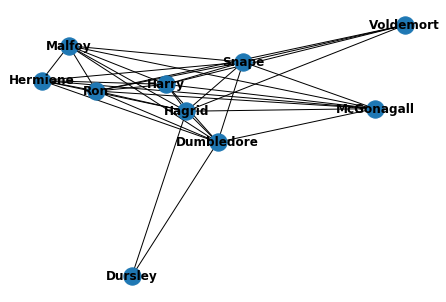

In [585]:
nx.draw(char_network, with_labels=True, font_weight='bold')

    We see that in our case, not everyone is connected to everyone, e.g. Voldemort is not directly connected with Malfoy (at least not in book 1) or Mrs McGonagall, but he has appeared in the same sentence with Snape, Harry and Hagrid.
    
    The professors are also connected with all the other professors (Snape, Hagrid, Dumbledore, and Mrs McGonnagall), which intuitively make sense.
    
    Dursley on the other hand, really isn't connected with anyone except Hagrid and Dumbledore. I suspect this is because Hagrid and Dumbledore were responsible for picking Harry up from the Dursley's, so they appeared in the same sentences for several times.

    Now let's examine the centrality of our network.

In [587]:
dcentralities = nx.degree_centrality(char_network)

In [597]:
sorted(dcentralities.items(), reverse = True, key = lambda x:x[1])

[('Hagrid', 1.0),
 ('Harry', 0.8888888888888888),
 ('Ron', 0.8888888888888888),
 ('Snape', 0.8888888888888888),
 ('Dumbledore', 0.8888888888888888),
 ('Hermione', 0.7777777777777777),
 ('Malfoy', 0.7777777777777777),
 ('McGonagall', 0.7777777777777777),
 ('Voldemort', 0.4444444444444444),
 ('Dursley', 0.2222222222222222)]

In [596]:
centralities = nx.betweenness.betweenness_centrality(char_network)
sorted(centralities.items(), reverse = True, key = lambda x:x[1])

[('Hagrid', 0.1388888888888889),
 ('Dumbledore', 0.08333333333333333),
 ('Harry', 0.027777777777777776),
 ('Ron', 0.027777777777777776),
 ('Snape', 0.027777777777777776),
 ('Hermione', 0.0),
 ('Malfoy', 0.0),
 ('McGonagall', 0.0),
 ('Dursley', 0.0),
 ('Voldemort', 0.0)]

    The result is a little surprising but reasonable, we see that for both measures (degree of centrality as well as betweeness centrality), Hagrid actually has a higher centrality score than Harry. For the betweeness measure, Dumbledore also scores higher than Harry. This suggests that while Harry is the protagnoist (he does have the highest centrality scores when we are considering all the words in the book), he did not connect all the characters together in the novel (by plot). Instead, in the book, Hagrid interacted with everyone and brought together the professors and the students. He was also responsible for picking Harry up from Dursley's, which explains his high centrality score in the character network.

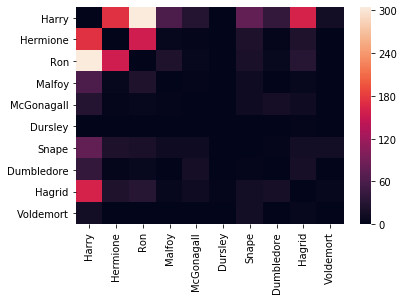

In [595]:
L = []
for node in char_network.nodes():
    l = []
    for node_ in char_network.nodes():
        if node == node_:
            l.append(0)
        else:
            if(node, node_) not in char_network.edges():
                l.append(0)
            else:
                l.append(char_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M_, columns = list(char_network.nodes()), index = list(char_network.nodes()))
ax = sb.heatmap(div)
plt.show()

    We see from the heatmap above that Harry, Hermione, Ron and Hagrid are more likely to be mentioned in the same sentence when compared with other characters.

## Conversational Analysis using ConvoKit

The accompanying notebook [convokit](https://github.com/Computational-Content-Analysis-2020/Content-Analysis-2020/blob/master/week-4/convokit.ipynb) demonstrates the capacities of CornellNLP's package convokit, which provides multiple ways to analyse networks of conversations.

There are 6 different approaches illustrated:

1. Measures of linguistic coordination
2. Politeness strategy
3. Prompt type
4. Hypergraph conversation representation
5  Linguistic diversity in conversations
6. Forecasting of conversation outcomes

The examples illustrate these methods using the built in datasets which ConvoKit offers. This [Jupyter notebook](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/converting_movie_corpus.ipynb) demonstrates how to convert your own corpora so that you can easily use the metrics provided in convokit. 

## <span style="color:blue">*Exercise 5*</span>

<span style="color:blue"> Implement one (or more) of the metrics from ConvoKit on your dataset of choice; what does it reveal about the social game of your dataset?

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.feature_selection import f_classif, SelectPercentile

from collections import defaultdict
from functools import partial
from multiprocessing import Pool

import convokit
from convokit import download
from convokit.prompt_types import PromptTypeWrapper
from convokit import PolitenessStrategies
from convokit import Corpus

**Coordination**  
A measure of linguistic influence (and relative power) between individuals or groups based on their use of function words.

    I will explore the convokit package using one of its own data, the supreme court corpus. In particular, I wish to see if lawayers coordinate to justices.

In [58]:
corpus = convokit.Corpus('/Users/Selina/.convokit/downloads/supreme-corpus')

In [59]:
# compute coordination scores on this corpus
coord = convokit.Coordination()
coord.fit(corpus)

# get coordination scores
coord.transform(corpus)

In [64]:
# get set of all justices
justices = list(corpus.iter_users(lambda user: user.meta["is-justice"]))
# get set of all users
lawyers = list(corpus.iter_users(lambda user: not user.meta["is-justice"]))

In [75]:
lawyers_to_justices = coord.score(corpus, lawyers, justices)
law_just = []
for lawyer, score in sorted(lawyers_to_justices.averages_by_user().items(),
    key=lambda x: x[1], reverse=True):
    law_just.append((lawyer.id, round(score, 5)))

In [76]:
print("Lawyers ranked by how much they coordinate to justices:")
law_just[:10]

Lawyers ranked by how much they coordinate to justices:


[('mr. bagenstos', 0.20148),
 ('mr. crooks', 0.13101),
 ('mr. multhaup', 0.1218),
 ('ms. perkell', 0.12037),
 ('mr. schroeder', 0.11492),
 ('mr. radmore', 0.11412),
 ('mr. heldman', 0.10849),
 ('ms. graeff', 0.09724),
 ('mr. porter', 0.09573),
 ('ms. woodman', 0.09404)]

In [72]:
justices_to_lawyers = coord.score(corpus, justices, lawyers, focus="targets")
just_law = []
for lawyer, score in sorted(justices_to_lawyers.averages_by_user().items(), 
    key=lambda x: x[1], reverse=True):
    just_law.append((lawyer.id, round(score, 5)))

In [74]:
print("Lawyers ranked by how much justices coordinate to them:")
just_law[:10]

Lawyers ranked by how much justices coordinate to them:


[('mr. kasner', 0.11235),
 ('mr. tillinghast', 0.10931),
 ('mr. radmore', 0.10594),
 ('mr. ayer', 0.10105),
 ('mr. stoepker', 0.1007),
 ('mr. robbins', 0.09483),
 ('mr. stancil', 0.08885),
 ('mr. cotter', 0.08691),
 ('mr. kuntz', 0.08517),
 ('mr. thomas', 0.08097)]

    We see that these two lists don't overlap. By values, we see that lawyers coordinate to justices more than justices coordiante to lawyers, which intuitively make sense.